## Project - Using Transfer Learning to classify different types of shoes.

In [49]:
# Importing modules.
import os
import sys
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [50]:
# Assigning the paths.
dir_path = os.getcwd()
data_path = os.path.join(dir_path, 'data')

In [51]:
# Listing the directories.
os.listdir(data_path)

['test', 'train']

In [52]:
# Train and Test data path.
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

In [53]:
# Listing types of shoes.
os.listdir(train_path)

['Boots', 'Sandals', 'Slippers']

In [81]:
# Total training data.
num_training_data = 0

for folder in os.listdir(train_path):
    num_training_data += len(os.listdir(os.path.join(train_path, folder)))
    
print('Number of training data is:', num_training_data)
print('Number of testing data is:', len(os.listdir(os.path.join(test_path, 'predict'))))

Number of training data is: 778
Number of testing data is: 89


In [55]:
# Assigning number of units of the output layer.
output_units = len(os.listdir(train_path))

print('Number of units in the output layer is:', output_units)

Number of units in the output layer is: 3


In [56]:
# Creating Image data generators for train and test set.

# Training generator.
train_generator = ImageDataGenerator(rescale = 1/255,
                                     preprocessing_function = preprocess_input,
                                     validation_split = 0.3)

# Testing generator.
test_generator = ImageDataGenerator(rescale = 1/255,
                                    preprocessing_function = preprocess_input)

In [57]:
# Initializing
IMAGE_SIZE = [224, 224]                     # Shape of input image required for InceptionV3.
BATCH_SIZE = 32                             # Assigning batch size.
CLASS_MODE = 'categorical'                  # Assigning class mode.

In [58]:
# Generating the data.

# Training data.
train_data = train_generator.flow_from_directory(train_path, 
                                                 target_size = tuple(IMAGE_SIZE),
                                                 class_mode = CLASS_MODE, 
                                                 subset = 'training',
                                                 shuffle = True,
                                                 batch_size = BATCH_SIZE)

# Validation data.
validation_data = train_generator.flow_from_directory(train_path, 
                                                      target_size = tuple(IMAGE_SIZE),
                                                      class_mode = CLASS_MODE, 
                                                      subset = 'validation',
                                                      shuffle = True,
                                                      batch_size = BATCH_SIZE)

# Testing data.
testing_data = test_generator.flow_from_directory(test_path, 
                                                  target_size = tuple(IMAGE_SIZE),
                                                  class_mode = None, 
                                                  shuffle = False,
                                                  batch_size = BATCH_SIZE)

Found 547 images belonging to 3 classes.
Found 231 images belonging to 3 classes.
Found 89 images belonging to 1 classes.


In [62]:
# Using VGG16 model.

# Instantiating.
vgg = VGG16(input_shape = IMAGE_SIZE + [3], include_top = False, weights = 'imagenet')

# Setting the layers to untrainable.
for layer in vgg.layers:
    layer.trainable = False

In [64]:
# Model.
x = Flatten()(vgg.output)
prediction = Dense(output_units, activation = 'linear')(x)

model = Model(inputs = vgg.input, outputs = prediction)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [66]:
# Compiling and fitting the model.

# Initialization.
EPOCHS = 5                                                       # Number of epochs.
STEPS_PER_EPOCH = train_data.n//train_data.batch_size            # Steps for every epoch in training set.
VAL_STEPS = validation_data.n//validation_data.batch_size        # Steps for every epoch in validation set.
PATIENCE = 5                                                     # Patience during LR on Plateau.
FACTOR = 0.1                                                     # Factor by which LR is reduced.

# Callbacks.
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = PATIENCE, factor = FACTOR)     # Defining LR on Plateau.
checkpoint = ModelCheckpoint(os.path.join(dir_path, 'model.h5'), save_best_only = True)       # Saving the best model.

# Compiling the model.
model.compile(loss = CategoricalCrossentropy(from_logits = True),
              optimizer = Adam(),
              metrics = [CategoricalAccuracy()])

# Fitting the model.
start_time = datetime.now()                                                                   # Time before training.

log_data = model.fit(train_data, steps_per_epoch = STEPS_PER_EPOCH,
                     validation_data = validation_data, validation_steps = VAL_STEPS,
                     epochs = EPOCHS, callbacks = [reduce_lr, checkpoint], verbose = 2)

elapsed_time = datetime.now() - start_time                                                    # Total time taken for training.
print('Time taken for training is:', elapsed_time)

Epoch 1/5
17/17 - 154s - loss: 4.1660 - categorical_accuracy: 0.5126 - val_loss: 1.1173 - val_categorical_accuracy: 0.6071
Epoch 2/5
17/17 - 153s - loss: 0.3575 - categorical_accuracy: 0.8893 - val_loss: 0.3611 - val_categorical_accuracy: 0.8839
Epoch 3/5
17/17 - 158s - loss: 0.0934 - categorical_accuracy: 0.9650 - val_loss: 0.0324 - val_categorical_accuracy: 0.9955
Epoch 4/5
17/17 - 160s - loss: 0.0228 - categorical_accuracy: 0.9981 - val_loss: 0.0394 - val_categorical_accuracy: 0.9866
Epoch 5/5
17/17 - 158s - loss: 0.0127 - categorical_accuracy: 0.9981 - val_loss: 0.0243 - val_categorical_accuracy: 0.9911
Time taken for training is: 0:13:07.022777


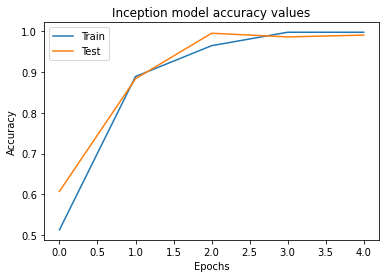

In [67]:
# Plotting.
plt.plot(log_data.history['categorical_accuracy'])
plt.plot(log_data.history['val_categorical_accuracy'])
plt.title('Inception model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [84]:
print('Training accuary is:', np.round(log_data.history['categorical_accuracy'][-1], 4))
print('Validation accuary is:', np.round(log_data.history['val_categorical_accuracy'][-1], 4))

Training accuary is: 0.9981
Validation accuary is: 0.9911


In [70]:
# Predictions.
predictions = model.predict(testing_data, batch_size = BATCH_SIZE)

In [77]:
# Creating a mapper to map the index values to the items.
mapper = {v: k for k, v in train_data.class_indices.items()}

In [79]:
# Mapping the values.
mapper_function = np.vectorize(lambda x: mapper.get(x))
final_predictions = mapper_function(predictions.argmax(axis = -1))

In [80]:
# Quick glance at the values.
final_predictions

array(['Sandals', 'Boots', 'Boots', 'Slippers', 'Boots', 'Slippers',
       'Boots', 'Sandals', 'Sandals', 'Boots', 'Boots', 'Boots', 'Boots',
       'Boots', 'Boots', 'Boots', 'Sandals', 'Sandals', 'Sandals',
       'Sandals', 'Sandals', 'Sandals', 'Boots', 'Sandals', 'Boots',
       'Boots', 'Boots', 'Boots', 'Slippers', 'Slippers', 'Boots',
       'Boots', 'Boots', 'Boots', 'Boots', 'Boots', 'Boots', 'Boots',
       'Boots', 'Boots', 'Boots', 'Boots', 'Boots', 'Sandals', 'Sandals',
       'Sandals', 'Slippers', 'Slippers', 'Sandals', 'Sandals',
       'Slippers', 'Sandals', 'Sandals', 'Slippers', 'Slippers', 'Boots',
       'Slippers', 'Slippers', 'Slippers', 'Slippers', 'Sandals',
       'Sandals', 'Sandals', 'Sandals', 'Slippers', 'Slippers', 'Boots',
       'Slippers', 'Slippers', 'Slippers', 'Slippers', 'Slippers',
       'Slippers', 'Slippers', 'Slippers', 'Slippers', 'Slippers',
       'Slippers', 'Slippers', 'Slippers', 'Slippers', 'Sandals',
       'Sandals', 'Slippers', 'Sa